## Wealth distribution dynamics

#### John Stachurski

This notebook gives an introduction to the evolution of weath distributions associated with different savings and income paths, along with related computational problems.

We focus on

* properties of the wealth distribution, such as degree of inequality

* how these properties are affected by wage income and financial income
    
* how to compute and represent an evolving sequence of distributions

We'll pick plausible savings rules rather than compute them via an optimization problem in order to simplify the presentation.  All of the techniques discussed here can be plugged into a model with optimization should you so desire.  

plot distribution time path, gini path, lorenz curve path under different assumptions about y.

plot size-rank plot for tails

In [108]:
import numpy as np
from numba import jit, njit, prange
import matplotlib.pyplot as plt


In [109]:
class Consumer:
    
    def __init__(self,
                 w_hat=1.0,
                 s_0=0.0,
                 s_1=0.4,
                 μ_y=0.5,
                 σ_y=0.2,
                 μ_R=0.2,
                 σ_R=0.2):
    
        self.w_hat = w_hat
        self.s_0, self.s_1 = s_0, s_1
        self.μ_y, self.σ_y = μ_y, σ_y
        self.μ_R, self.σ_R = μ_R, σ_R
        
        self.R_mean = np.exp(μ_R + 0.5 * σ_R**2)
        self.y_mean = np.exp(μ_y + 0.5 * σ_y**2)
        
        # Test stability condition and compute stationary mean estimate
        α = self.R_mean * self.s_1
        if α < 1:
            self.w_bar = self.y_mean / (1 - α)
        else:
            error_msg = f"Stability condition failed with α = {α}"
            raise ValueError(error_msg)
            
    def unpack_parameters(self):
        """
        Collect and return parameters.
        """
        parameters = (self.w_hat, self.s_0, self.s_1,
                      self.μ_y, self.σ_y,
                      self.μ_R, self.σ_R)
        return parameters
        
    def update_function_builder(self):
        """
        A function factory that returns a function with one task:
        update wealth from w_t to w_{t+1}.
        """
        # Unpack parameters
        parameters = self.unpack_parameters()
        w_hat, s_0, s_1, μ_y, σ_y, μ_R, σ_R = parameters
        
        @njit
        def update(w):
            """
            Update wealth one period, given current wealth w.
            """
            y = np.exp(μ_y + σ_y * np.random.randn())   
            R = np.exp(μ_R + σ_R * np.random.randn())
            s = s_0 if w < w_hat else s_1
            return R * s * w + y
        
        return update
    

In [110]:
@njit
def wealth_time_series(w_0, h, ts_length=100_000):
    w = np.empty(ts_length)
    w[0] = w_0
    for t in range(ts_length-1):
        w[t+1] = h(w[t])
    return w

In [111]:
@njit
def cross_section(in_distribution, h, shift_length=100):
    """
    Updates each w_t in in_distribution to w_{t+j} where
    j = shift_length.  Returns the new distribution.
    """
    out_distribution = np.empty_like(in_distribution)
    for i, w in in_distribution:
        for t in range(shift_length):
            w = h(w)
        out_distribution[i] = w
    return out_distribution

In [112]:
cns = Consumer()

In [113]:
f = cns.update_function_builder()

In [114]:
time w = wealth_time_series(cns.w_bar, f, ts_length=1000)

CPU times: user 127 ms, sys: 0 ns, total: 127 ms
Wall time: 124 ms


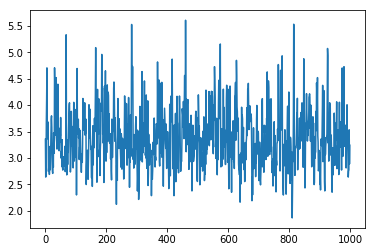

In [115]:
fig, ax = plt.subplots()
ax.plot(w)
plt.show()